In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph/props"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, load_checkpoint, initialize_models
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 
from mol_opt.ot_utils import compute_barycenter

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics
from molgen.Discretizer.sinkhorn import sinkhorn_knopp

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from molgen.metrics.Penalty import Penalty as PenaltyNew
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [2]:
model_type = "deepsets"
sys.argv = ["", "-model_type", model_type, "-one_batch_train"]
args = get_args()
args.n_epochs = 100 
args.init_model = "{}-attention-random-gcn2-sink1-test13".format(model_type)
args.output_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/output_dev4/{}/".format(args.init_model)
# args.output_dir = "/run/media/octav/data-volume/tum-thesis/output_dev4_saves/{}/".format(args.init_model)
args.tb_logs_dir = "/home/octav/gitrepos/tum-thesis/mol_opt/logs_dev4/{}".format(args.init_model)
args.batch_size = 50 

In [42]:
model = args.init_model
model_iter = 1500

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)

molopt, molopt_decoder, _, pen, recpen, crossatt, _, config, _ = load_checkpoint(args.output_dir + model_name ,init_fc = initialize_models, device = args.device)

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False, device = args.device)
fgw_loss = FGW(alpha = 0.5)
# pen = PenaltyNew(config, model_iter)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)
pen.log()

/home/octav/gitrepos/tum-thesis/mol_opt/output_dev4/deepsets-attention-random-gcn2-sink1-test13/model_deepsets-attention-random-gcn2-sink1-test13_1500
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (GCN2): GCN(
    (W_message_i): Linear(in_features=100, out_features=200, bias=False)
    (W_message_h): Linear(in_features=200, out_features=200, bias=False)
    (W_message_o): Linear(in_features=293, out_features=150, bias=True)
    (W_mol_h): Linear(in_features=150, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (d

In [43]:
# train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)
datatype = "train"
train_data_loader = get_loader("molgen/data/chembl50", datatype, 50, same_number_atoms = True)

for i in train_data_loader:
#     X = (MolGraph(i[0]))
#     Y = (MolGraph(i[1]))
    X = MolGraph(i)
    Y = X
    break

In [44]:
x_encoding, x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
# yhat_labels = molopt_decoder.discretize_gumbel(*yhat_logits, tau = pen.tau)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

pen.mirror = ""

if config.cross_att_use:
    y_encoding = molopt.GCN2(Y)[0]
    cross_mats, ot_loss = crossatt.forward(x_embedding, y_encoding, X, model_type)
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats, atoms = args.fgw_atoms, bonds = args.fgw_bonds)
else:
    fgw_loss_item = fgw_loss(*pred_pack, tau = 1)

pen.tau = 0.05
print (fgw_loss_item.item()/args.batch_size)
pen_loss = pen(*pred_pack, model_iter)
print (pen_loss, ot_loss.item()/args.batch_size)
metrics.measure_batch(pred_pack[0], target)

0.2783677291870117
(tensor(5589.7002, grad_fn=<DivBackward0>), tensor(869.0449, grad_fn=<DivBackward0>), tensor(859.4025, grad_fn=<DivBackward0>)) -0.8556410217285156


({'batch_molecular_validity': 0.0,
  'batch_correctness': 0.0,
  'batch_symbol_accuracy': 97.30434782608695,
  'batch_molecular_disconnected_validity': 72.0,
  'batch_connected_components': 18.52,
  'batch_invalid_valency_nodes': 75.65217391304348,
  'batch_nodes_0degree': 850,
  'batch_nodes_7plus_degree': 3,
  'invalid_euler_toofew': 96.0,
  'invalid_euler_toomany': 0.0},
 {'avg_euler_error': (-18.139999999999997, 50, 108.24039999999997),
  'batch_node_degree': (0.5269565217391305, 1150, 1.2370994328922498)})

In [45]:
for i in molopt.GCN.parameters():
    print (i)

Parameter containing:
tensor([[-0.0327,  0.0192, -0.0106,  ..., -0.0349, -0.0690, -0.0953],
        [-0.0737, -0.0053,  0.0287,  ..., -0.0317, -0.0889, -0.0358],
        [-0.0811, -0.1425,  0.0185,  ..., -0.0245, -0.2251,  0.0743],
        ...,
        [-0.1091, -0.0810, -0.1143,  ..., -0.0202,  0.0381, -0.0436],
        [-0.0834,  0.0432,  0.0419,  ..., -0.0485,  0.0528, -0.0244],
        [-0.0777, -0.1314, -0.1364,  ..., -0.0914,  0.1432, -0.1928]],
       requires_grad=True)
Parameter containing:
tensor([[ 2.7776e-02,  1.8422e-02, -9.7220e-03,  ..., -4.0347e-02,
          2.5684e-02, -2.4032e-02],
        [ 4.3333e-02, -4.7625e-02,  9.6365e-03,  ...,  3.6630e-02,
         -4.8227e-02, -8.7885e-02],
        [ 1.1693e-02,  1.2603e-02, -5.3725e-01,  ...,  4.0139e-02,
          4.0240e-02,  8.2426e-03],
        ...,
        [-3.8937e-04, -3.3491e-02,  4.6645e-02,  ..., -7.5834e-02,
          4.2388e-02, -3.6956e-02],
        [ 9.0902e-03, -1.2827e-02, -5.6864e-02,  ..., -3.9439e-02,
   

In [46]:
fgw_loss_item

tensor(13.9184, grad_fn=<AddBackward0>)

In [47]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# cap_value = 1e-02
# 
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod, eigenvectors=True)[0] # IMPORTANT: need to compute eigenvectors for autograd
# capped = torch.clamp(eigenvals, min=1e-6, max=1e-02)
# print (eigenvals)
# -torch.sum(torch.log(capped)) + len(eigenvals) * np.log(cap_value)

In [48]:
print([x.item() / args.batch_size for x in pen_loss])
print(bonds_labels.unique(return_counts = True))

[111.79400390625, 17.3808984375, 17.188050537109376]
(tensor([0, 1, 4]), tensor([  366,   120, 29022]))


In [49]:
target_bond_counts = torch.zeros(len(BOND_TYPES))
for i in range(len(target)):
    target_bond_counts += target[i]["BOND_TYPES"].sum(axis = (0,1))
print(target_bond_counts.int())

tensor([ 1768,   716,     4,     0, 27020], dtype=torch.int32)


In [50]:
y_embedding = y_encoding
yhat_embedding = x_embedding

def hmap(dfr):
    sns.heatmap(dfr.cpu().detach().numpy(), cmap = sns.color_palette("rocket_r", as_cmap=True))
    plt.show()
    
def project_2d(dfr):
    yhat_np = dfr.cpu().detach().numpy()
    yhat_mean = np.mean(yhat_np.T, axis = 1)
    yhat_nomean = yhat_np - yhat_mean
    cov = np.cov(yhat_nomean.T)
    values, vectors = np.linalg.eig(cov)
    proj = vectors[:,:2].T.dot(yhat_nomean.T)
    return proj

Model name: model_deepsets-attention-random-gcn2-sink1-test13_1500
Type=deepsets, random=True, epoch=1500, index=0
random dim selected 0
M


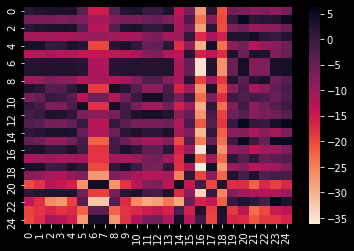

attn


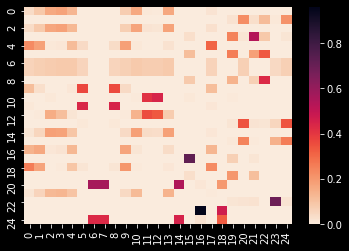

W 0


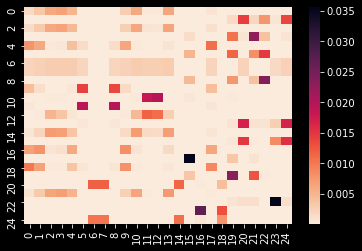

tensor([0.0386, 0.0393, 0.0385, 0.0389, 0.0396, 0.0401, 0.0223, 0.0223, 0.0401,
        0.0393, 0.0386, 0.0383, 0.0387, 0.0393, 0.0224, 0.0511, 0.0277, 0.0380,
        0.0252, 0.0608, 0.0530, 0.0529, 0.0512, 0.0508, 0.0529],
       grad_fn=<SumBackward1>)
tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
       grad_fn=<SumBackward1>)

Mgrad


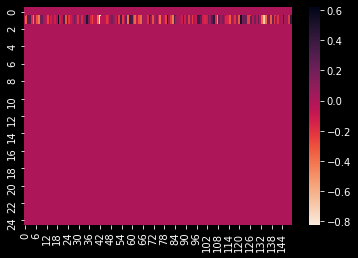

attgrad


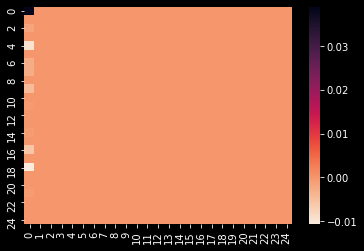

Wgrad


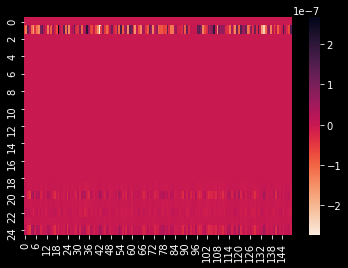

lossgrad


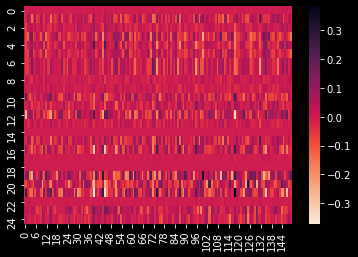

In [77]:
cross_mats = []
loss = torch.tensor(0.)
for idx, (stx, lex) in enumerate(X.scope):
    y = y_embedding[stx:stx+lex]
    # these things vary because of the different types of embedding for diff models
    if model_type == "deepsets":
        yhat = yhat_embedding[stx:stx+lex]
    elif model_type == "molemb":
        yhat = yhat_embedding[idx][:lex]
    # print(y.shape, self.k.shape, self.q.shape, yhat.shape)
#     M = 1/np.sqrt(crossatt.cross_att_dim) * torch.matmul(torch.matmul(y, crossatt.k), torch.matmul(crossatt.q.T, yhat.T))
#     M = torch.matmul(crossatt.k1(F.leaky_relu(crossatt.k0(y))), crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
    if config.cross_att_use_gcn2:
        M = torch.matmul(y, crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
    else:
        M = torch.matmul(crossatt.k1(F.leaky_relu(crossatt.k0(y))), crossatt.q1(F.leaky_relu(crossatt.q0(yhat))).T)
#     M = M.clamp(-5, 5)
    if config.cross_att_sigmoid:
        M = nn.Sigmoid()(M) * 5
    
    print ("Model name:", model_name)
    print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
    if crossatt.args.cross_att_random:
        dim = np.random.randint(2)
        print ("random dim selected", dim)
    else:
        dim = 1
        
    print ("M")
    hmap(M)


    attn = torch.softmax(M, dim = dim)
    loss_vec = attn.sum(axis = 1 - dim)
    loss += torch.sum(-torch.log(loss_vec) * loss_vec)
    print ("attn")
    hmap(attn)
    W = (attn + crossatt.eps)/(len(attn))
    # if idx == 0:
    #     print (W.sum(axis = 0))
    #     print (W.sum(axis = 1))
    #     print ()
#     W2 = sinkhorn_knopp(W, -0.1, numItermax=1)
#     print ("new sinkhorn")
#     hmap(W2)
#     if idx == 0:
#         print (W2.sum(axis = 0))
#         print (W2.sum(axis = 1))
#         print ()
    
    W_in = W
#     for idx2 in range(crossatt.args.cross_att_n_sinkhorn):
    for idx2 in range(1):
        dim = 1 - dim
        W = (W.transpose(0,dim) / W.sum(axis = dim)).transpose(0,dim)
        W = W/(len(W))
#         if idx2 == crossatt.args.cross_att_n_sinkhorn-1:
        if True:
            print ("W",idx2)
            hmap(W)
            print (W.sum(axis = 0))
            print (W.sum(axis = 1))
            print ()
#     print ("W",idx2+1)
#     hmap(W)
    
    cross_mats.append(W)
    
    print ("Mgrad")
    hmap(grad(M[1,1], yhat, retain_graph = True)[0])
    
    print ("attgrad")
    hmap(grad(attn[0,0], M, retain_graph = True)[0])
    
    print ("Wgrad")
    hmap(grad(W[1,1], yhat, retain_graph = True)[0])
    
#     print ("W2grad")
#     hmap(grad(W2[1,1], W, retain_graph = True)[0])

    print ('lossgrad')
    hmap(grad(loss, y, retain_graph = True)[0])
    
    if idx == 0:
        break

In [68]:
print (loss)
loss_vec

tensor(-1.4038, grad_fn=<AddBackward0>)


tensor([0.9306, 0.9689, 0.8756, 0.9190, 0.9696, 0.9435, 0.6243, 0.6243, 0.9224,
        0.8924, 0.8767, 0.8492, 0.8982, 0.8959, 0.6195, 1.2839, 0.4478, 1.0558,
        0.6843, 1.2097, 1.8711, 1.5310, 0.8122, 1.5931, 1.7012],
       grad_fn=<SumBackward1>)

In [22]:
loss_vec = W.sum(axis = 1-dim)
print (torch.sum(-torch.log(loss_vec) * loss_vec))
print (torch.sum(-torch.log(loss_vec + crossatt.eps) * loss_vec))

tensor(3.1645, grad_fn=<SumBackward0>)
tensor(3.1645, grad_fn=<SumBackward0>)


In [23]:
nn.Sigmoid()(M)

tensor([[9.3518e-01, 9.4091e-01, 9.6094e-01, 9.6125e-01, 9.6194e-01, 8.8034e-01,
         9.8254e-06, 9.8254e-06, 9.1304e-01, 9.6286e-01, 9.4418e-01, 8.5498e-01,
         8.8403e-01, 9.5650e-01, 1.4922e-07, 1.8520e-03, 5.4270e-10, 9.4506e-01,
         2.2769e-09, 1.3366e-02, 3.1971e-03, 1.3487e-03, 3.7811e-03, 5.2772e-04,
         2.4391e-02],
        [1.3225e-02, 5.9299e-03, 1.7630e-03, 7.9161e-04, 1.6186e-03, 6.3917e-03,
         2.2901e-06, 2.2901e-06, 6.2527e-03, 1.7977e-03, 9.0042e-04, 7.8193e-04,
         9.8708e-04, 1.5213e-03, 6.7510e-08, 3.7669e-01, 3.5676e-09, 5.8538e-03,
         1.3394e-09, 8.5706e-01, 5.7043e-01, 8.9712e-01, 9.7756e-01, 5.5591e-01,
         5.3055e-01],
        [9.2556e-01, 9.3277e-01, 9.5850e-01, 9.5943e-01, 9.6026e-01, 8.5998e-01,
         1.8426e-05, 1.8426e-05, 8.9707e-01, 9.6207e-01, 9.4525e-01, 8.6112e-01,
         8.9962e-01, 9.5621e-01, 1.6450e-07, 7.0282e-04, 2.5680e-10, 9.4347e-01,
         9.1287e-10, 5.3085e-03, 5.9502e-03, 3.3867e-04, 1.7015e-

In [24]:
loss_vec = attn.sum(axis = 0)
torch.sum(-torch.log(loss_vec) * loss_vec)

tensor(1.1921e-07, grad_fn=<SumBackward0>)

In [25]:
attn.sum(axis = 0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

In [26]:
nn.Sigmoid()(M)

tensor([[9.3518e-01, 9.4091e-01, 9.6094e-01, 9.6125e-01, 9.6194e-01, 8.8034e-01,
         9.8254e-06, 9.8254e-06, 9.1304e-01, 9.6286e-01, 9.4418e-01, 8.5498e-01,
         8.8403e-01, 9.5650e-01, 1.4922e-07, 1.8520e-03, 5.4270e-10, 9.4506e-01,
         2.2769e-09, 1.3366e-02, 3.1971e-03, 1.3487e-03, 3.7811e-03, 5.2772e-04,
         2.4391e-02],
        [1.3225e-02, 5.9299e-03, 1.7630e-03, 7.9161e-04, 1.6186e-03, 6.3917e-03,
         2.2901e-06, 2.2901e-06, 6.2527e-03, 1.7977e-03, 9.0042e-04, 7.8193e-04,
         9.8708e-04, 1.5213e-03, 6.7510e-08, 3.7669e-01, 3.5676e-09, 5.8538e-03,
         1.3394e-09, 8.5706e-01, 5.7043e-01, 8.9712e-01, 9.7756e-01, 5.5591e-01,
         5.3055e-01],
        [9.2556e-01, 9.3277e-01, 9.5850e-01, 9.5943e-01, 9.6026e-01, 8.5998e-01,
         1.8426e-05, 1.8426e-05, 8.9707e-01, 9.6207e-01, 9.4525e-01, 8.6112e-01,
         8.9962e-01, 9.5621e-01, 1.6450e-07, 7.0282e-04, 2.5680e-10, 9.4347e-01,
         9.1287e-10, 5.3085e-03, 5.9502e-03, 3.3867e-04, 1.7015e-

In [27]:
# get cross entropy loss
loss = nn.CrossEntropyLoss()
loss_vec = attn.sum(axis = 1 - dim)
# loss_vec
loss(loss_vec, loss_vec)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [28]:
torch.matmul(y, crossatt.k)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

In [29]:
torch.matmul(crossatt.q.T, yhat.T)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [30]:
cross_mats[0]

tensor([[2.1634e-03, 2.4547e-03, 4.6742e-03, 4.6152e-03, 4.6181e-03, 1.0514e-03,
         4.1554e-08, 4.1554e-08, 1.5052e-03, 4.5607e-03, 3.7527e-03, 1.6325e-03,
         2.0743e-03, 4.3703e-03, 3.9904e-08, 6.4945e-07, 3.9871e-08, 2.5178e-03,
         3.9871e-08, 4.9671e-06, 1.8806e-07, 5.6235e-07, 1.7325e-06, 6.4604e-08,
         1.1854e-06],
        [3.2326e-06, 1.5134e-06, 5.9211e-07, 2.9535e-07, 5.3005e-07, 1.5128e-06,
         6.3506e-08, 6.3506e-08, 1.4855e-06, 5.6260e-07, 3.7823e-07, 4.0466e-07,
         4.8697e-07, 5.4058e-07, 6.2911e-08, 3.1322e-04, 6.2889e-08, 1.4222e-06,
         6.2888e-08, 3.4398e-03, 9.6830e-05, 5.3213e-03, 3.0641e-02, 9.2554e-05,
         8.1743e-05],
        [1.9337e-03, 2.2182e-03, 4.5511e-03, 4.5628e-03, 4.5782e-03, 9.1028e-04,
         4.4623e-08, 4.4623e-08, 1.2956e-03, 4.6279e-03, 3.9718e-03, 1.7805e-03,
         2.5291e-03, 4.5017e-03, 4.1387e-08, 2.8098e-07, 4.1349e-08, 2.5332e-03,
         4.1349e-08, 2.0544e-06, 3.2815e-07, 1.7727e-07, 8.2965e-

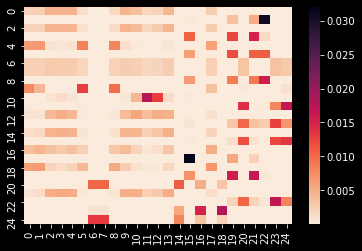

In [31]:
hmap(cross_mats[0])

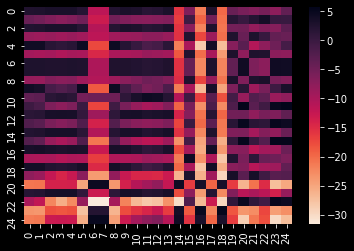

In [32]:
hmap(M)
plt.show()

In [33]:
hmap(torch.matmul(y, crossatt.k))

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

In [34]:
hmap(torch.matmul(crossatt.q.T, yhat.T))

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [35]:
# proj = project_2d(torch.matmul(y, crossatt.k))

# K * Y (GCN embedding)
proj = project_2d(crossatt.k1(F.leaky_relu(crossatt.k0(y))))
plt.scatter(proj[0], proj[1])
plt.show()

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k1'

/home/octav/anaconda3/envs/mol_ot/lib/python3.6/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


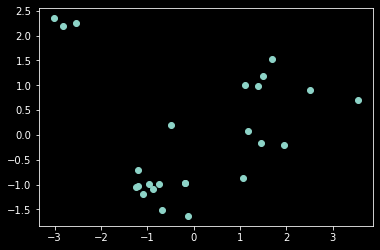

In [36]:
# Y (GCN embedding)
proj = project_2d(y)
plt.scatter(proj[0], proj[1])
plt.show()

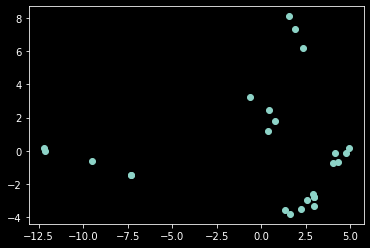

In [37]:
# Q * Yhat (barycenter embedding)
proj = project_2d(crossatt.q1(F.leaky_relu(crossatt.q0(yhat))))
plt.scatter(proj[0], proj[1])
plt.show()

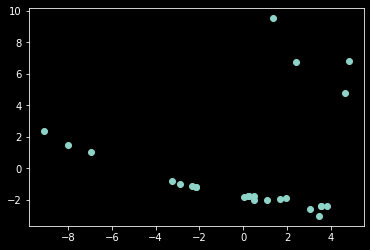

In [38]:
# Yhat (barycenter embedding)
proj = project_2d(yhat)
plt.scatter(proj[0], proj[1])
plt.show()

In [39]:
# check out errors from the penalty terms
M_fgw, pred_bonds_nll, target_bonds_rescaled = fgw_loss(*pred_pack, tau = 1, ot_plans = cross_mats, debug = True)

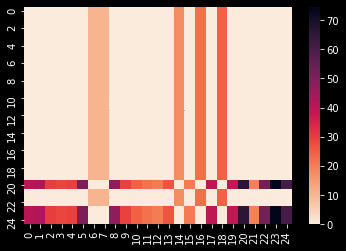

In [40]:
hmap(M_fgw)

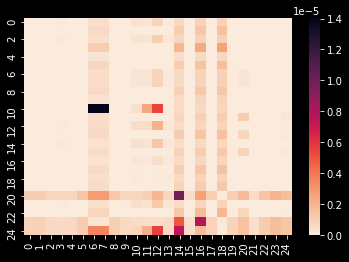

In [41]:
hmap(W * M_fgw)

In [49]:
pred_bonds_nll.shape

torch.Size([22, 22, 5])

In [50]:
target_bonds_rescaled.shape

torch.Size([22, 22, 5])

In [24]:
y.shape

torch.Size([22, 150])

In [25]:
crossatt.k.shape

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

In [26]:
proj = project_2d(torch.matmul(crossatt.q.T, yhat.T))
plt.scatter(proj[0], proj[1])
plt.show()

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [27]:
hmap(crossatt.q)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [28]:
hmap(crossatt.k)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'k'

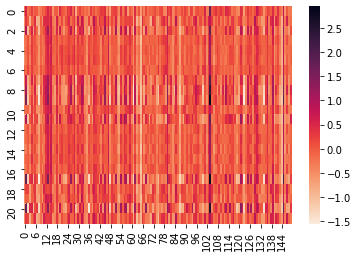

In [29]:
hmap(y)

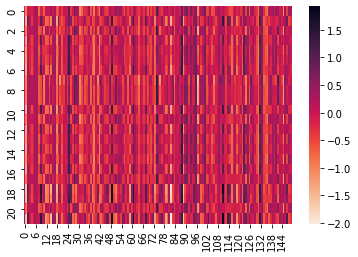

In [30]:
hmap(yhat)

In [31]:
cross_mats[0].sum(axis = 0)

tensor([0.0357, 0.0524, 0.0526, 0.0337, 0.0506, 0.0330, 0.0512, 0.0335, 0.0341,
        0.0509, 0.0495, 0.0482, 0.0486, 0.0496, 0.0421, 0.0336, 0.0505, 0.0496,
        0.0505, 0.0533, 0.0334, 0.0634], grad_fn=<SumBackward1>)

In [32]:
cross_mats[0].sum(axis = 1)

tensor([0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
        0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
        0.0455, 0.0455, 0.0455, 0.0455], grad_fn=<SumBackward1>)

In [33]:
G_fgw = grad(fgw_loss_item, x_embedding, retain_graph = True)
G_euler = grad(pen_loss[2], bonds_logits, retain_graph = True)
G_k = grad(fgw_loss_item, crossatt.k, retain_graph = True, allow_unused = True)
G_q = grad(fgw_loss_item, crossatt.q, retain_graph = True, allow_unused = True)

print(G_euler[0].abs().mean().item())
print(G_fgw[0].abs().mean().item())
print()
print(np.mean((torch.sum(G_euler[0], dim = 1) == 0).cpu().detach().numpy()))
print(np.mean((torch.sum(G_fgw[0], dim = 1) == 0).cpu().detach().numpy()))
print()
print(symbols_logits.abs().mean().item())
print(bonds_logits.abs().mean().item())

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

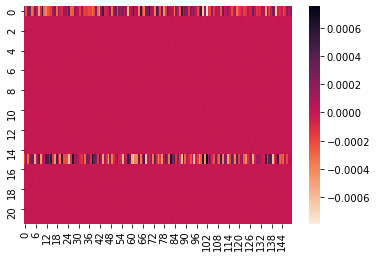

In [34]:
hmap(grad(cross_mats[idx][0,0], yhat, retain_graph = True)[0])

In [35]:
grad(cross_mats[idx][0,2], yhat, retain_graph = True)[0]

tensor([[-8.7584e-06,  1.1433e-05, -1.5590e-05,  ..., -1.5702e-05,
          1.3490e-06, -5.6331e-06],
        [ 1.1783e-05, -3.4147e-06,  1.7988e-05,  ...,  2.3681e-05,
          2.4206e-06,  1.6833e-05],
        [ 1.2964e-03, -8.8816e-04,  1.8948e-03,  ...,  2.1740e-03,
         -3.0954e-04,  4.8717e-04],
        ...,
        [-2.3757e-08,  5.4631e-08, -2.7509e-08,  ..., -1.7404e-08,
         -1.6488e-08,  9.0098e-09],
        [-1.1862e-04,  1.1880e-04, -2.0369e-04,  ..., -2.3381e-04,
          6.3850e-05, -9.2342e-05],
        [-1.3955e-06,  1.0099e-05, -8.8733e-06,  ..., -5.0284e-06,
          1.2868e-06,  4.5920e-06]])

In [36]:
grad(crossatt.q[0,0], yhat, retain_graph = True, allow_unused = True)

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [37]:
crossatt.q

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

In [38]:
crossatt.q

ModuleAttributeError: 'CrossAttUnit' object has no attribute 'q'

# get 2d projections of embedding

In [41]:
x_embedding.shape

torch.Size([22, 150])

Model name: model_deepsets-attention-sinknew-test8_1000
Type=deepsets, random=False, epoch=1000, index=0


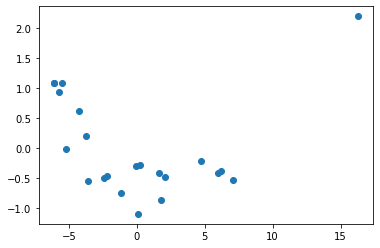

In [42]:
print ("Model name:", model_name)
print ("Type={}, random={}, epoch={}, index={}".format(model_type, config.cross_att_random, model_iter, idx))
plt.scatter(proj[0], proj[1])
plt.show()

In [71]:
yhat_np = yhat.cpu().detach().numpy()
yhat_mean = np.mean(yhat_np.T, axis = 1)
yhat_nomean = yhat_np - yhat_mean
cov = np.cov(yhat_nomean.T)
values, vectors = np.linalg.eig(cov)
proj = vectors[:,:2].T.dot(yhat_nomean.T)

In [72]:
np.linalg.eig(yhat_np)

LinAlgError: Last 2 dimensions of the array must be square

In [73]:
yhat_np.shape

(22, 150)

In [74]:
bonds_logits_softmaxed = nn.Softmax(dim = 1)(bonds_logits)

In [75]:
grad(bonds_logits_softmaxed[:,4].sum(), bonds_logits, retain_graph = True)[0].sum()

tensor(3.3938e-06)

In [76]:
bonds_logits_softmaxed

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.8833e-04, 2.3093e-04, 2.2682e-10, 2.5118e-10, 9.9948e-01],
        [3.0985e-04, 2.8335e-04, 3.5862e-10, 3.6073e-10, 9.9941e-01],
        ...,
        [2.4729e-04, 4.3778e-05, 3.6786e-11, 4.8702e-11, 9.9971e-01],
        [2.7051e-04, 1.2587e-04, 2.5589e-11, 3.3114e-11, 9.9960e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       grad_fn=<SoftmaxBackward>)

In [77]:
x_embedding.shape

torch.Size([22, 150])

In [78]:
bond_idx = 0
smiles = []

yhat = []
yact = []
for mol_idx, (st, le) in enumerate(Y.scope):
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le)
    bond_idx += le * le
    smiles.append(feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False))
    yhat.append(le)
    yact.append((bonds != 4).sum().item()/2.)
    print (mol_idx, yact[-1], le)
    print (smiles[-1])
    
yhat = np.array(yhat)
yact = np.array(yact)


0 0.0 22
C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.O


(array([ 2.,  2.,  2.,  5.,  7., 10., 11.,  5.,  3.,  3.]),
 array([-41. , -37.4, -33.8, -30.2, -26.6, -23. , -19.4, -15.8, -12.2,
         -8.6,  -5. ]),
 <BarContainer object of 10 artists>)

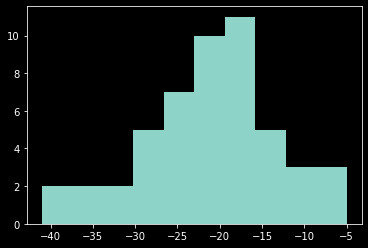

In [36]:
plt.hist(yact - yhat)

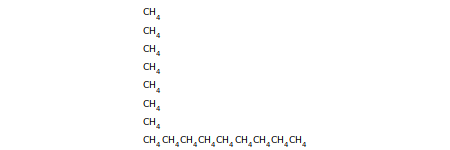

In [37]:
Chem.MolFromSmiles(smiles[1], sanitize = False)

In [38]:
np.arange(0,1000,100)

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [106]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0])

In [107]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(7.9200, grad_fn=<MaxBackward1>)

In [108]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="{}-{}-{}-manual2-".format(args.init_model, model_iter, datatype))

CCCCCC1(C)CC(CO)C1(O)CCOC
C=CCCCCCCC(N)(CC)C(CCC)C(N)CC(O)NC
CCCCC(C)CC(C)C(C)C(N)(NC(C)C)C(CSC)C(N)CC(O)NF
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)CC(O)NO
CCC1CN[SH](C)CC(CN)C(N)CCN1N
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)OC(O)NO
CCC1CCC12CC(CO)C2(O)OCN
NCOC1CC(N)S12CCC2
CNC1CN[SH](C)CC(CN)C(N)CCN1N
OCCC(O)(OCO)C1CCC1
CCCCC(O)C1CC(C)CCCCCCC1C
C=CCCC=CCCC(N)C(CCC)C(O)CC(O)NC
CCC1(O)OC(O)N(O)C(C)(CN(C)OC)C(C)C(C)(CC)C(O)C(N)(N)(NC(O)(O)O)C1CCCN(N)O.O
NCCC(O)(OCN)[SH]1CCC1
CCCCC(C)CC(C)CC(N)(NCC)C(CCC)C(O)CC(O)NCl
CNC(N)(CCCC(C)CCOC)C(CSC)C(O)OC(O)NCl
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CCCCC(C)CC(C)C(C)C(N)(NC(C)O)C(CCCC)C(O)CC(O)NC
CCCC(C)(CCC)C1CCC1CC
CCCCCCCCC(N)(N)C(CCC)C(N)CC(O)NO
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CC1CCCC1C
CCCCCC1(C)CC(CC)C1(O)CCCC
CCC(O)CC(O)C1CC(C)C(C)CCCCCC1C
CC1CCCCCC(O)C(C(O)OC(O)OO)CC1C
C=CCCC(C)C(C)C(C)C(C)C(N)(OC(C)C)C(CCCC)C(O)CC(O)NC
CCC1CCC1C(O)(CCN)CCN
C=CCCC(C)CC(C)C(C)C(N)(CC(C)C)C(CCCC)C(O)CC(O)CC
C=CCCC(C)CC(C)C(C)C(N)(CC(C)C)C(CCCC)C(C)CC(O)NC
CC12CC1COC2O
CC1CCOC1O


In [27]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.N.N.O.O.O.O'

In [67]:
tau = pen.tau
# tau = 0.001
# symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)
# symbols_nll, charges_nll, bonds_nll = -nn.LogSoftmax(dim=1)(symbols_logits/tau),\
#              -nn.LogSoftmax(dim=1)(charges_logits/tau), -nn.LogSoftmax(dim=1)(bonds_logits/tau)

def softmax(logits, tau):
#     logitsn = F.normalize(logits, dim = 1)
#     return -nn.LogSoftmax(dim=1)(logitsn/tau)
    return F.gumbel_softmax(tau = tau, dim=1, logits = logits)

symbols_nll = softmax(symbols_logits, tau)
charges_nll = softmax(charges_logits, tau)
bonds_nll = softmax(bonds_logits, tau)

In [68]:
pen.tau

0.05195383849590577

(array([201., 231., 302., 166., 129.,  31.,  15.,   3.,   0.,   1.]),
 array([ 47.78911,  64.59665,  81.40419,  98.21173, 115.01927, 131.82681,
        148.63435, 165.4419 , 182.24944, 199.05698, 215.86452],
       dtype=float32),
 <a list of 10 Patch objects>)

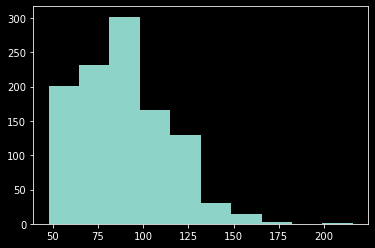

In [39]:
plt.hist(symbols_logits.norm(dim = 1).cpu().detach().numpy())

(array([  24.,   19.,   36.,   26.,   17.,   32.,   31.,   21.,   36.,
          33.,   37.,   35.,   64.,   66.,   97.,   71.,   65.,   86.,
          72.,   75.,  106.,   87.,   79.,   95.,   68.,   72.,   76.,
          61.,   81.,   70.,   63.,   71.,   53.,   74.,   68.,   62.,
          30.,   37.,   45.,   40.,   58.,   32.,   65.,   58.,   57.,
          55.,   50.,   64.,   82.,   32.,   38.,   50.,   59.,   44.,
          49.,   49.,   50.,   68.,   49.,   55.,   66.,   43.,   49.,
          92.,   82.,   55.,   79.,   63.,   89.,   84.,   65.,   75.,
         101.,   97.,   83.,  111.,   99.,  111.,  130.,  119.,  118.,
         137.,  127.,  147.,  109.,  161.,  210.,  198.,  219.,  271.,
         338.,  430.,  511.,  560.,  580.,  880., 1053., 1574., 2603.,
        8307.]),
 array([0.2980454 , 0.30506495, 0.3120845 , 0.31910405, 0.3261236 ,
        0.33314312, 0.34016266, 0.3471822 , 0.35420176, 0.3612213 ,
        0.36824086, 0.3752604 , 0.38227996, 0.38929948, 0.39631903

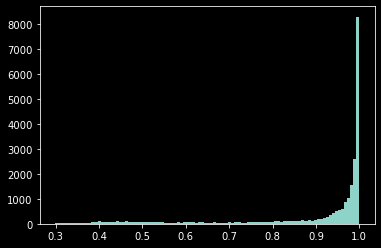

In [52]:
max_logits = torch.max(F.softmax(dim=1, input = bonds_logits), dim = 1).values.detach().cpu().numpy()
plt.hist(max_logits, bins = 100)

In [26]:
symbols_logits.shape

torch.Size([1079, 64])

<BarContainer object of 64 artists>

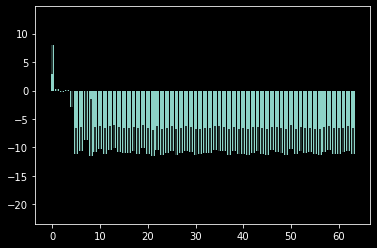

In [70]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

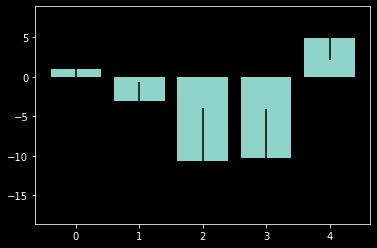

In [71]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [101]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([27,  4, 53,  ...,  4,  7, 50], device='cuda:0')

In [102]:
bonds_logits.sum(axis = 1)

tensor([-0.7168, -0.6918, -0.7858,  ..., -0.2435, -0.3567, -0.3224],
       device='cuda:0', grad_fn=<SumBackward1>)

In [103]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[1.1898e-07, 4.1788e-15, 1.1364e-11,  ..., 1.1246e-15, 4.4671e-12,
         2.6455e-06],
        [5.9730e-32, 3.8587e-35, 2.3728e-35,  ..., 2.7590e-26, 4.3688e-35,
         6.8968e-34],
        [2.3369e-16, 5.9282e-12, 9.6984e-11,  ..., 5.1900e-19, 7.2133e-17,
         2.6491e-13],
        ...,
        [1.0000e+00, 1.0524e-29, 1.8007e-29,  ..., 5.9074e-30, 3.6392e-36,
         2.7992e-31],
        [3.3421e-20, 3.4711e-14, 4.9880e-17,  ..., 4.9878e-09, 9.8660e-22,
         7.0411e-26],
        [5.2386e-27, 2.3484e-27, 5.3644e-35,  ..., 3.0511e-31, 3.9224e-33,
         6.2579e-37]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [104]:
bonds_nll

tensor([[30.4351, 34.9901, 82.9673, 68.6483, -0.0000],
        [35.5620, 39.7150, 82.7646, 71.0517, -0.0000],
        [36.0503, 39.9646, 83.9324, 70.3454, -0.0000],
        ...,
        [26.6836, 38.2859, 91.0719, 90.3248, -0.0000],
        [20.4135, 28.7948, 73.8399, 72.7646, -0.0000],
        [21.0419, 32.0101, 80.5401, 78.0148, -0.0000]], device='cuda:0',
       grad_fn=<NegBackward>)

In [105]:
torch.argmax(bonds_nll, dim = 1).unique(return_counts = True)

(tensor([2, 3, 4], device='cuda:0'),
 tensor([13527, 10041,     3], device='cuda:0'))

In [72]:
bonds_nll

tensor([[4.8684e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1608e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.1414e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        ...,
        [3.8970e-18, 1.0000e+00, 3.2179e-41, 3.9096e-43, 7.6519e-09],
        [1.8544e-17, 6.8090e-20, 0.0000e+00, 5.7014e-10, 1.0000e+00],
        [0.0000e+00, 5.8267e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [73]:
bond_idx = 0
for st, le in Y.scope:
    bonds_nll_curr = bonds_nll[bond_idx:bond_idx + le**2,:].view(le, le, -1)
    print ((1 - bonds_nll_curr[:,:,4]).sum()/2)
    bond_idx += le**2

tensor(25.9540, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(15.7227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(30.8190, device='cuda:0', grad_fn=<DivBackward0>)
tensor(26.7959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21.0293, device='cuda:0', grad_fn=<DivBackward0>)
tensor(18.0473, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.4608, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.6883, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4789, device='cuda:0', grad_fn=<DivBackward0>)
tensor(22.8743, device='cuda:0', grad_fn=<DivBackward0>)
tensor(24.2297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(29.8443, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.9637, device='cuda:0', g

In [75]:
1 - bonds_nll_curr[:,:,4]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2863e-01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.3452e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0364e-02, 0.0000e+00, 9.9963e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9987e-01, 1.9908e-05, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5497e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.4771e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2620e-01, 0.0000e+00, 0.0000e+00,
         9.1592e-01, 3.3100e-03, 0.0000e+00],
        [1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [118]:
symbols_logits.shape

torch.Size([1079, 64])

In [119]:
symbols_labels

tensor([2, 0, 0,  ..., 0, 0, 0], device='cuda:0')

# inspect module parameters

In [150]:
molopt_decoder.fc1_SYMBOLS

Linear(in_features=100, out_features=150, bias=True)

In [151]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

tensor([[ 13.7881,   0.6913,   3.3530,  ..., -10.6195,  -8.9924, -11.0378],
        [ 13.5698,  -1.3311,   4.9047,  ...,  -8.9976,  -7.9215, -10.1074],
        [  5.2691,  -6.6067,   3.9132,  ..., -13.3723, -13.1498, -14.1045],
        ...,
        [  2.3633,   0.6043,   8.5959,  ..., -12.3276, -12.1154, -13.7442],
        [ 16.1051,   0.3792,   4.5413,  ...,  -8.0192,  -7.4203,  -9.7780],
        [  8.6492,   4.9261,   0.4580,  ...,  -9.5743,  -9.4313, -10.6167]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [152]:
x_embedding

tensor([[-0.1335,  0.4283,  0.3699,  ..., -0.3710,  0.7165, -0.5101],
        [-0.8927,  1.3656,  0.6950,  ..., -1.0309, -0.1640, -0.0162],
        [-0.4414, -0.3376,  2.9654,  ...,  1.0029, -0.6166,  0.1708],
        ...,
        [ 0.9006,  0.2762, -0.7614,  ...,  1.1360,  0.2881, -0.2464],
        [-1.4002,  1.4269, -0.5393,  ..., -1.6091,  0.4275, -0.0564],
        [-0.5014,  0.6323,  0.1265,  ..., -1.6008, -0.1383,  0.4430]],
       device='cuda:0', grad_fn=<AddBackward0>)

# debug connectivity

In [153]:
def get_pen(model_iter):
    model_name = "model_{}_{}".format(model, model_iter)
    model_decode_name = "model_{}_decode_{}".format(model, model_iter)
    molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
    molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
    x_embedding = molopt.forward(X)
    yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
    yhat_labels = molopt_decoder.discretize_argmax(*yhat_logits)
    # yhat_labels = molopt_decoder.discretize(*yhat_logits)
    pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

    return (pen(*pred_pack, model_iter)[1].item())

In [154]:
for i in range(0, 2000):
    print (i, get_pen(1600))

FileNotFoundError: [Errno 2] No such file or directory: 'mol_opt/output_transformer10-onebatch/model_transformer10-onebatch-nonconstrained_1600'

In [ ]:
# adjM = pen_loss
# N = adjM.shape[0]
# device = adjM.device
# # We need the laplacian otherwise
# L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM # Laplacian
# L_mod = L + torch.ones_like(L, device=device) / N
# eigenvals = torch.symeig(L_mod + 1e-06 * torch.eye(N, device=device), eigenvectors=True)[0]
# -torch.sum(torch.log(eigenvals.clamp(max = 1e-01))) + len(eigenvals) * np.log(1e-01)

In [ ]:
F.gumbel_softmax(symbols_logits, dim=1, tau=0.5)